In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
import string
from tqdm import trange

sns.set_style('darkgrid')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch.cuda.current_device(), torch.cuda.get_device_name(0)

if torch.cuda.is_available():  
    dev = 'cuda:0' 
else:  
    dev = 'cpu'

## Resumen:

1. Quitando símbolos tóxicos (", espacios, !, etc) tenemos los siguientes resultados:
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
2. Quitando símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
3. Sin quitar símbolos tóxicos (", espacios, !, etc), es decir, dataset original:
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
4. Sin quitar símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
Para la LSTM lo mejor parece ser la opción 1. Lo mejor hasta ahora es con `(EMBEDDING_DIM = 20 HIDDEN_DIM = 20 EPOCHS = 25)` (test=0.581, aunque no se fijó la semilla y no se puede reproducir).

## Preprocesamiento

In [3]:
from utils import (color_toxic_words, remove_symbols, completely_toxic, separate_words, 
                   get_index_toxic_words, f1)

In [4]:
train = pd.read_csv('Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})

In [5]:
train['spans_clean'] = train['spans']

In [6]:
# Pondremos los que tienen [ ] como completamente tóxicos para ver qué sale.

clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]
train['spans_clean'] = clean_spans

In [7]:
# Quitamos símbolos

indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
train['spans_clean'] = indices_clean

In [8]:
# Pasamos a minúscula
train['text'] = train['text'].apply(lambda x:x.lower())

## LSTM

In [9]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens))

In [10]:
test_data = []
for index, text in zip(test['spans'], test['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens))

In [11]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix.get(w, 0) for w in seq]      # Si no está que lo ponga como 'UNK'
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [12]:
word_to_ix = {'UNK': 0}

for sent, tags in train_data:
    for word in sent:
        if word not in word_to_ix:              # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
tag_to_ix = {"non_toxic": 0, "toxic": 1}        # Assign each tag with a unique index

In [13]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Usar otro embedding, tratar con alguno que haya en 'transformers'
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [14]:
def tagger_LSTM(text):
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = word_tokenize(text.lower())
    
    with torch.no_grad():
        inputs = prepare_sequence(words, word_to_ix)
        tag_scores = model(inputs)
        tags = [np.argmax(x.cpu().numpy()) for x in tag_scores]

        tagged_sentence = [(word, ix_to_tag[tag]) for word,tag in zip(words, tags)]

    return tagged_sentence

def f1_scores(df):
    scores_LSTM = []
    for gold_index, text in df.values:
        tagged_sentence = tagger_LSTM(text)   
        prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
        scores_LSTM.append(f1(prediction_index, gold_index))
        
    return np.mean(scores_LSTM)

def plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test, show=True):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    ax0.plot(np.arange(1, len(train_loss) + 1), train_loss, marker='o', label='train_loss')
    ax0.plot(np.arange(1, len(test_loss) + 1), test_loss, marker='o', label='validation loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, 
             marker='o', label='f1 score in train')
    ax1.plot(np.arange(1, len(f1_scores_test) + 1), f1_scores_test, 
             marker='o', label='f1 score in test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 score')
    ax1.legend()

    if show:
        plt.show()

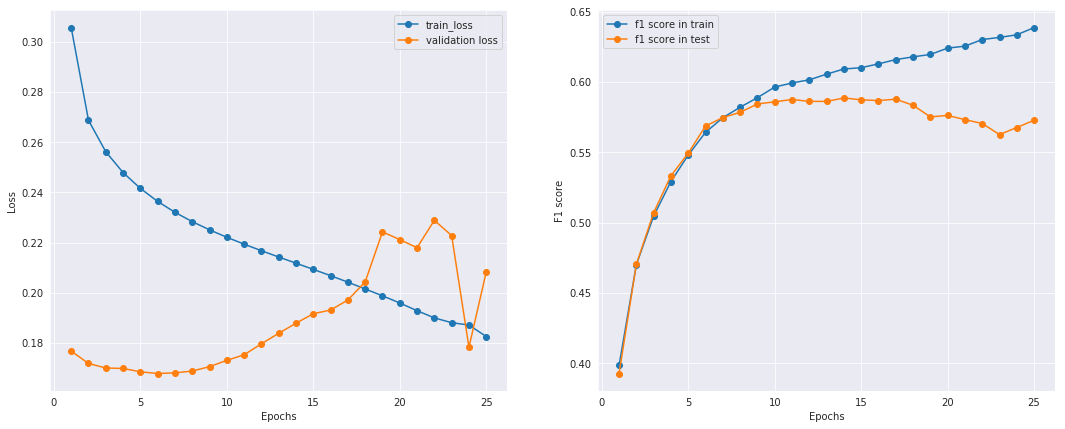

100%|██████████| 25/25 [13:52<00:00, 33.30s/it]


In [15]:
# Deben ir en la misma celda donde se entrena, de lo contrario no fija la semilla
torch.manual_seed(100)
# np.random.seed()

# These will usually be more like 32 or 64 dimensional.
EMBEDDING_DIM = 20
HIDDEN_DIM = 20
EPOCHS = 25

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
model.to(torch.device(dev)) # Lo mueve a la GPU, en caso de que haya
# model.cuda()              # Pasa todo a la GPU, da error si no hay GPU        
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

with torch.no_grad():
    inputs = prepare_sequence(train_data[0][0], word_to_ix)
    tag_scores = model(inputs)
#     print(tag_scores)
 
train_loss = []
test_loss = []
f1_scores_train = []
f1_scores_test = []

for epoch in trange(EPOCHS): 
    train_val = 0.0
    test_val = 0.0
    for sentence, tags in train_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        train_val += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss.append(train_val/len(train_data))
                
    for sentence, tags in test_data:
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)     
        
        tag_scores = model(sentence_in)
        
        loss_test = loss_function(tag_scores, targets)
        test_val += loss_test.item()
        
    test_loss.append(test_val/len(test_data))
    
    f1_scores_train.append(f1_scores(train[['spans', 'text']]))
    f1_scores_test.append(f1_scores(test[['spans', 'text']]))
    
    clear_output(wait=True)
    plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test)
            
# torch.save(model, 'Models/LSTM_20.pt')

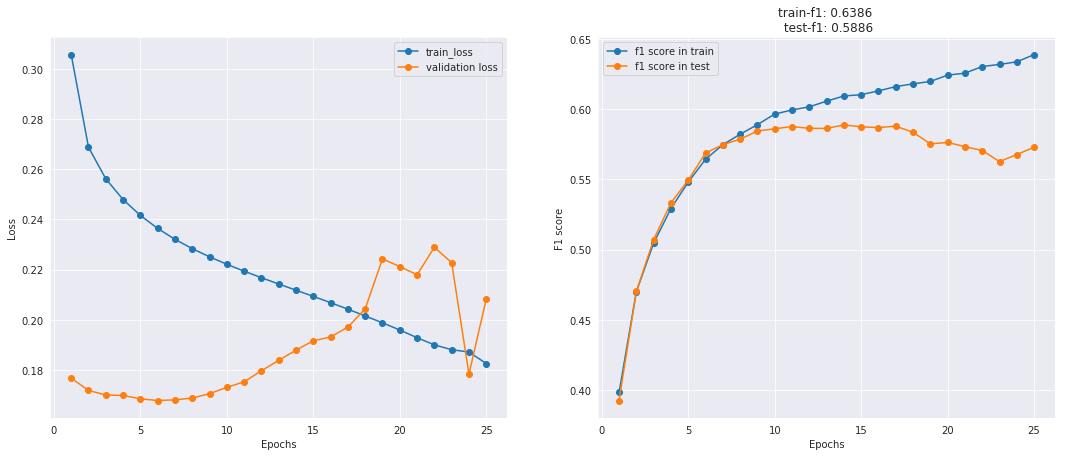

In [16]:
plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test, show=False)
plt.title('train-f1: {:.4f} \n test-f1: {:.4f}'.format(np.max(f1_scores_train), np.max(f1_scores_test)))
plt.savefig('Images/preprocesamiento-4.png', bbox_inches='tight')
plt.show()

## Evaluación

In [17]:
evaluation = pd.read_csv('Datos/tsd_test.csv')
evaluation.head()

,text
0,That's right. They are not normal. And I am st...
1,"""Watch people die from taking away their healt..."
2,tens years ago i contacted the PDR and suggest...
3,The parallels between the ANC and the Sicilian...
4,Intel Community: ‘How can we work for a Presid...


In [18]:
indices_evaluation = []
for text in evaluation['text']:
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_evaluation.append(prediction_index)
#     print(colored('Pred: ', color='cyan', attrs=['bold']) + 
#           color_toxic_words(prediction_index, text)) 

In [19]:
evaluation['spans'] = indices_evaluation
evaluation = evaluation[['spans', 'text']]
evaluation.head()

,spans,text
0,"[133, 134, 135, 136, 137, 138, 140, 141, 142, ...",That's right. They are not normal. And I am st...
1,"[54, 55, 56, 57, 59, 60, 61, 62, 81, 82, 83, 8...","""Watch people die from taking away their healt..."
2,"[483, 484, 485, 486, 487, 488, 489, 490, 492, ...",tens years ago i contacted the PDR and suggest...
3,"[413, 414, 415, 416, 417, 418, 419, 420]",The parallels between the ANC and the Sicilian...
4,"[126, 127, 128, 129, 130, 271, 272, 273, 274, ...",Intel Community: ‘How can we work for a Presid...


Para la evaluación se debe subir un zip con un archivo txt de la siguiente manera (al final subir el archivo `spans-pred.zip` que se produce):

In [20]:
predictions = evaluation['spans'].tolist()
ids = evaluation.index.tolist()

with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")
        
# Zip the predictions
! zip -r spans-pred.zip ./spans-pred.* 

updating: spans-pred.txt (deflated 82%)
